In [1]:
import torch 
import tensorflow as tf
import torch.nn as nn
import numpy as np
import gym
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
from state_indep_ppo import PPO

2025-02-27 10:27:50.523338: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 10:27:50.558515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 10:27:51.372003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Get PPO Generated Samples

In [2]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [3]:
env = gym.make("Pendulum-v1")
actionspace = env.action_space.shape[0]
obsspace = env.observation_space.shape[0]
print(f"actionspace: {actionspace}, obs space {obsspace}")
rollout_buffer = []
agent = PPO(
    ob_space=obsspace,
    actions=actionspace,
    n_batches=10,
    gamma=0.95   ,
    lam=0.95,
    kl_coeff=0.2,
    clip_rewards=False,
    clip_param=0.2,
    vf_clip_param=10.0,
    entropy_coeff=0,
    a_lr=5e-4,
    c_lr=5e-4,
    device='cpu',
    max_ts=100,

    # Any custom kwargs can also be passed in here. For example:
    rollouts_per_batch=5,
    max_timesteps_per_episode=200,
    n_updates_per_iteration=3,
)

# 3. Train the agent
total_timesteps = 2000//5  # Decide how long you want to train
rollouts = agent.learn(total_timesteps=total_timesteps, env=env, rollout_buffer= rollout_buffer)

actionspace: 1, obs space 3
Learning... Running 200 timesteps per episode, 5 timesteps per batch for a total of 400 rollouts


/home/tristongrayston/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Rollouts:  88%|████████████████████████████████████████████████████▌       | 350/400 [03:13<00:26,  1.87it/s, loss=-296]

Achieves a rolling average loss of greater than -300, which is considered optimal. Breaking training loop...


Rollouts: 100%|████████████████████████████████████████████████████████████| 400/400 [03:40<00:00,  1.82it/s, loss=-646]


In [109]:

states = []
actions = []

for s, a in rollouts:
    states.append(s)
    actions.append(a)

states_t = torch.stack(states)
actions_t = torch.stack(actions)

# A lot of samples. I mean ideally we'd take 20 rollouts of 1000 out of hte back half. 

training_states = states_t[340:365, :, :]
training_actions = actions_t[340:365, :, :]

In [110]:
training_states = training_states.reshape(training_states.shape[0]* training_states.shape[1], training_states.shape[2])
training_actions = training_actions.reshape(training_actions.shape[0]* training_actions.shape[1], training_actions.shape[2])

training_states.shape

torch.Size([25000, 3])

In [111]:

# Suppose `states` and `actions` each have shape (20, 1000, 3)
# where 20 = number of rollouts, 1000 = time steps, 3 = dimension of state/action
# Example:
# states = torch.randn(20, 1000, 3)
# actions = torch.randn(20, 1000, 3)


states_t_list = []
states_t1_list = []

num_rollouts, state_dim = training_states.shape
# actions has shape (20, 1000, 3) as well, i.e. (num_rollouts, seq_len, action_dim)
_, action_dim = training_actions.shape

for i in range(20000):
    # Example: keep only the first dimension of state (states[i, t, 0])
    # and keep all 3 action dimensions => total size is 4
    curr_s_first_dim = training_states[i, :].unsqueeze(0)   # shape [1]
    curr_a = training_actions[i, :].unsqueeze(0)                         # shape [3]

   # print(curr_s_first_dim.shape, " " , curr_a.shape)

    # Concatenate into a single 4-D vector
    # If you want *all* state dimensions, you'd do: torch.cat([states[i,t,:], actions[i,t,:]])
    s_plus_a = torch.cat([curr_s_first_dim, curr_a], dim=1)  # shape [4]

    # Next state is s_{t+1} (we'll keep all 3 dims here)
    s_next = training_states[i + 1, :]  # shape [3]

    states_t_list.append(s_plus_a) 
    states_t1_list.append(s_next)

# Finally stack them:
states_t = torch.stack(states_t_list)   # shape [num_rollouts*(seq_len-1), 4]
states_t1 = torch.stack(states_t1_list) # shape [num_rollouts*(seq_len-1), 3]

states_t = states_t.squeeze(1)
print("states_t shape =", states_t.shape)   # e.g. [19980, 4] if 20 x 999
print("states_t1 shape =", states_t1.shape) # e.g. [19980, 3]


states_t shape = torch.Size([20000, 4])
states_t1 shape = torch.Size([20000, 3])


In [112]:
# fact check

print(states_t[0], " ", training_states[0])
print(states_t1[0], " ", training_states[1])

tensor([-0.6969, -0.7172, -0.6887,  1.0907])   tensor([-0.6969, -0.7172, -0.6887])
tensor([-0.7340, -0.6791, -1.0630])   tensor([-0.7340, -0.6791, -1.0630])


# Train on PPO Generated Samples

states_t = [20000, 4]

states_t1 = [20000, 3]

## NCPS

In [119]:
from ncps.wirings import NCP
out_features = 3
in_features = 4

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=6, command_neurons=6, motor_neurons=out_features,
             sensory_fanout=6, inter_fanout=6, recurrent_command_synapses=0, motor_fanin=6)

world_model = CfC(in_features, wiring, batch_first=True, activation='swish') # change to cfc, what could go wrong?
learn = SequenceLearner(world_model, lr=0.001)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=10,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [120]:
#inputs = torch.tensor(inputs, dtype=torch.float32)
#outputs = torch.tensor(outputs, dtype=torch.float32)

dataloader = data.DataLoader(
    data.TensorDataset(states_t, states_t1), batch_size=256, shuffle=True, num_workers=8
)

In [121]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 855    | train
---------------------------------------
696       Trainable params
159       Non-trainable params
855       Total params
0.003     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.


## DNN

In [38]:
def build_world_model():
    xin_s = tf.keras.layers.Input((3,))
    xin_noise = tf.keras.layers.Input((3,))

    xs = tf.keras.layers.Add()([xin_s, xin_noise])
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)

    xin_a = tf.keras.layers.Input((1,))
    xa = tf.keras.layers.Dense(32, activation='swish')(xin_a)

    xs = tf.keras.layers.Concatenate()([xs,xa])
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)
    xs = tf.keras.layers.Dense(3)(xs)
    return tf.keras.models.Model([xin_s, xin_noise, xin_a], xs)

build_world_model().summary()

2025-02-27 11:06:48.191567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 11:06:48.241373: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3)         │          0 │ input_layer[0][0… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         64 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │         99 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,427 (13.39 KB)

 Trainable params: 3,427 (13.39 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
inputs = states_t.numpy()
outputs = states_t1.numpy()
inputs.shape

(20000, 4)

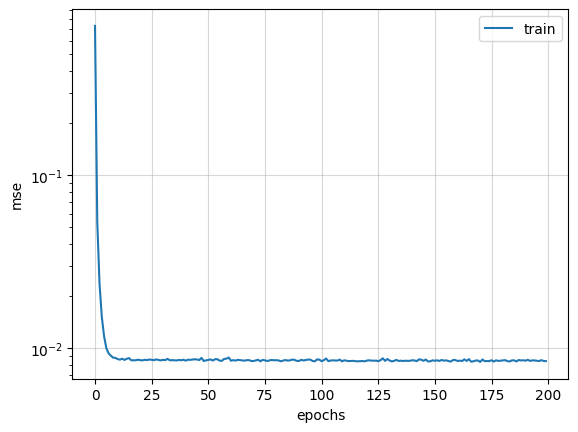

In [43]:
DNN_world_model = build_world_model()
DNN_world_model.compile(loss='mse',optimizer='adam')

#inputs = inputs.reshape(inputs.shape[0] * inputs.shape[1], inputs.shape[2])
#outputs = outputs.reshape(outputs.shape[0] * outputs.shape[1], outputs.shape[2])

#dnn_inputs = tf.tensor(inputs)
#dnn_outputs = tf.tensor(outputs)

hist = DNN_world_model.fit([inputs[:,:3], # states
                        np.random.randn(20000,3)*0, # noise applied to states
                        inputs[:,3:]], # actions
                       outputs, batch_size = 256, epochs = 200, verbose=0)

plt.plot(hist.history['loss'],label='train')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.yscale('log')
plt.grid(alpha=0.5);

### Test time

In [122]:
states_t_list = []
states_t1_list = []

num_rollouts, state_dim = training_states.shape
# actions has shape (20, 1000, 3) as well, i.e. (num_rollouts, seq_len, action_dim)
_, action_dim = training_actions.shape

for i in range(4000):
    # Example: keep only the first dimension of state (states[i, t, 0])
    # and keep all 3 action dimensions => total size is 4
    curr_s_first_dim = training_states[i + 20000, :].unsqueeze(0)   # shape [1]
    curr_a = training_actions[i+ 20000, :].unsqueeze(0)                         # shape [3]

   # print(curr_s_first_dim.shape, " " , curr_a.shape)

    # Concatenate into a single 4-D vector
    # If you want *all* state dimensions, you'd do: torch.cat([states[i,t,:], actions[i,t,:]])
    s_plus_a = torch.cat([curr_s_first_dim, curr_a], dim=1)  # shape [4]

    # Next state is s_{t+1} (we'll keep all 3 dims here)
    s_next = training_states[i+ 20000 + 1, :]  # shape [3]

    states_t_list.append(s_plus_a) 
    states_t1_list.append(s_next)

# Finally stack them:
states_t = torch.stack(states_t_list)   # shape [num_rollouts*(seq_len-1), 4]
states_t1 = torch.stack(states_t1_list) # shape [num_rollouts*(seq_len-1), 3]
#states_t = states_t.squeeze(1)

In [123]:

print(states_t[0], " ", training_states[0])
print(states_t1[0], " ", training_states[1])

tensor([[-0.5559, -0.8313, -0.0246,  0.8562]])   tensor([-0.6969, -0.7172, -0.6887])
tensor([-0.5773, -0.8166, -0.5196])   tensor([-0.7340, -0.6791, -1.0630])


In [124]:
#t_outputs = t_n_obs

x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(4000):
    c_inputs = states_t[i]
    #print(c_inputs.shape)
    with torch.no_grad():
        prediction = world_model(states_t[i])[0].numpy()
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - states_t1[i, 0].numpy())
    y_residuals.append(prediction[:, 1] - states_t1[i, 1].numpy())
    ang_vel_residuals.append(prediction[:, 2] - states_t1[i, 2].numpy())

NCPS_x_res = np.stack(x_residuals).T
NCPS_y_res = np.stack(y_residuals).T
NCPS_ang_res = np.stack(ang_vel_residuals).T
print(NCPS_x_res.shape)

(1, 4000)


In [125]:
states_t = states_t.squeeze(1)

In [126]:
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

print(states_t[:].numpy().shape)
print(states_t1[:].numpy().shape)

#c_inputs = torch.FloatTensor(t_inputs[:, i, :])
prediction = np.array(DNN_world_model.predict([states_t[:, :3].numpy(),
                                  np.zeros((states_t.shape[0],3)),
                                  states_t[:, 3:].numpy()])).squeeze()

# add residuals
#prediction = t_outputs[:, i, :] + prediction

# save predictions
set_of_predictions.append(prediction)

# get residuals
x_residuals.append(prediction[:, 0] - states_t1[:, 0].numpy())
y_residuals.append(prediction[:, 1] - states_t1[:, 1].numpy())
ang_vel_residuals.append(prediction[:, 2] - states_t1[:, 2].numpy())

DNN_x_res = np.stack(x_residuals).T
DNN_y_res = np.stack(y_residuals).T
DNN_ang_res = np.stack(ang_vel_residuals).T
print(DNN_y_res.shape)


(4000, 4)
(4000, 3)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(4000, 1)


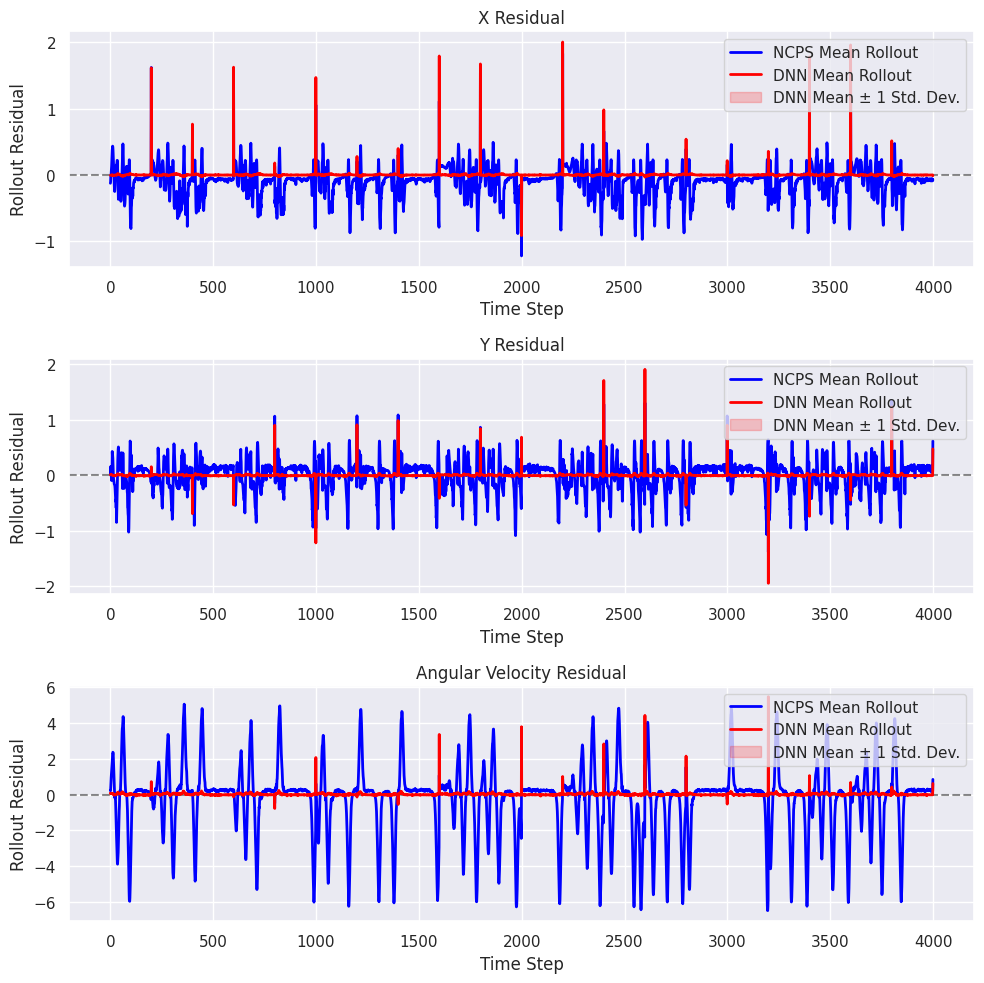

In [127]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(4000)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    #std_rollout = res_1.std(axis=0)
    #ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
     #               color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')

    # Compute and plot the mean
    mean_rollout = res_2.mean(axis=0)
    ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    std_rollout = res_2.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], NCPS_x_res, DNN_x_res.T, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_y_res, DNN_y_res.T, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], NCPS_ang_res, DNN_ang_res.T, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


(4000,)
(4000, 1)
0.004847469
-0.097486325


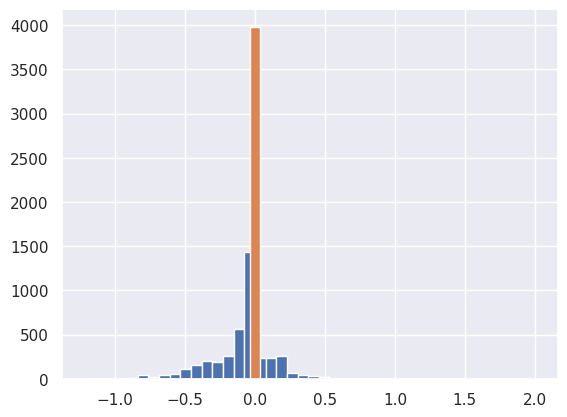

In [129]:
import seaborn as sns
sns.set()

rng = np.random.default_rng(19680801)

N_points = 4000
n_bins = 40

# Generate two normal distributions
dist1 = rng.standard_normal(N_points)

print(dist1.shape)
print(DNN_x_res.shape)
#dist2 = 0.4 * rng.standard_normal(N_points) + 5

#plt.subplots(1, 2, sharey=True, tight_layout=True)

plt.hist(NCPS_x_res.T, bins=n_bins)
plt.hist(DNN_x_res, bins=n_bins)
print(np.mean(DNN_x_res))
print(np.mean(NCPS_x_res))